# _Pre-Requisite: Make sure you have run the notebooks in the `SETUP` and `INGEST` sections._

# Visualize ADA monthly aggregated data enriched with age group label

# Prepare Dataset
- internal app segment dataset : s3://ada-prod-data/etl/data/brq/sub/app/monthly/{country}/{month}/
- app reference dataset : 
    - app data path: s3://ada-prod-data/reference/app/master_all/all/all/all/app.csv
    - app level data path: s3://ada-prod-data/reference/app/app_level/all/all/all/app_level.csv
- age label data : s3://ada-dev/etl/ml/age/data/label/MY/

In [1]:
!pip install pyarrow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import configparser
import os

from pyspark import SparkConf
import sagemaker_pyspark
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.window import Window

import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
app_segment_path = "s3a://ada-prod-data/etl/data/brq/sub/app/monthly/MY/202001/"
app_data_path = "s3a://ada-prod-data/reference/app/master_all/all/all/all/app.csv"
app_level_path = "s3a://ada-prod-data/reference/app/app_level/all/all/all/app_level.csv"
age_label_path = "s3a://ada-dev/etl/ml/age/data/label/MY/final"

device_path = "s3a://ada-prod-data/etl/data/brq/sub/device/monthly/MY/202001/"

In [6]:
aws_profile = "default"
config = configparser.ConfigParser()
config.read(os.path.expanduser("~/.aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id") 
access_key = config.get(aws_profile, "aws_secret_access_key")
aws_session_token = config.get(aws_profile, "aws_session_token")

In [7]:
# from pyspark import SparkConf
# import sagemaker_pyspark
# from pyspark.sql import SparkSession

# spark = SparkSession.builder.appName("schema_test").getOrCreate()
# #         .config(conf=conf) \
# #         .config('fs.s3a.access.key', access_id)\
# #         .config('fs.s3a.secret.key', access_key)\
        

In [8]:
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))

spark = SparkSession.builder \
        .appName("schema_test") \
        .config(conf=conf) \
        .config('fs.s3a.access.key', access_id)\
        .config('fs.s3a.secret.key', access_key)\
        .getOrCreate()

In [9]:
hadoop_conf=spark.sparkContext._jsc.hadoopConfiguration()

hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
hadoop_conf.set("fs.s3a.access.key", access_id)
hadoop_conf.set("fs.s3a.secret.key", access_key)
hadoop_conf.set("fs.s3a.session.token", aws_session_token)
hadoop_conf.set("fs.s3a.fast.upload", "true")
hadoop_conf.set("fs.s3a.buffer.dir", "/tmp")

In [10]:
app_segment_df = spark.read.parquet(app_segment_path)
# app_data_df = spark.read.csv(app_data_path,header = True)
# app_level_df = spark.read.csv(app_level_path,header = True)
age_label_df = spark.read.parquet(age_label_path)
device_df = spark.read.parquet(device_path)

In [12]:
app_segment_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- app: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- app_name: string (nullable = true)
 |    |    |-- bundle: string (nullable = true)
 |    |    |-- genre: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- segment: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- L1: string (nullable = true)
 |    |    |-- L2: string (nullable = true)
 |    |    |-- L3: string (nullable = true)
 |    |    |-- brq_count: long (nullable = true)



# Dataset preprocessing

In [46]:
app_filtered = app_segment_df.select("ifa",F.explode("app").alias("app")).select("ifa","app.app_name",F.explode("app.genre").alias("genre")) #,"app.L1","app.L2","app.L3"

In [22]:
app_filtered.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- genre: string (nullable = true)



In [23]:
app_filtered.show(truncate = False)

+------------------------------------+-------------------------------------------------+----------------+
|ifa                                 |app_name                                         |genre           |
+------------------------------------+-------------------------------------------------+----------------+
|00000000-1d1e-9f59-0000-00002b17f0eb|iflix - Movies, TV Series & News                 |ENTERTAINMENT   |
|00000000-2092-26a1-0000-00002b17f0eb|iflix - Movies, TV Series & News                 |ENTERTAINMENT   |
|00000000-2533-1c30-0000-00002b17f0eb|iflix - Movies, TV Series & News                 |ENTERTAINMENT   |
|00000000-4faa-abcc-0000-00002b17f0eb|iflix - Movies, TV Series & News                 |ENTERTAINMENT   |
|00000000-7f86-6d17-0000-00002b17f0eb|iflix - Movies, TV Series & News                 |ENTERTAINMENT   |
|00016d69-935a-4362-933a-6aecd947e48c|SHAREit - Transfer & Share                       |TOOLS           |
|00016d69-935a-4362-933a-6aecd947e48c|Worms Zo

In [47]:
app_join_age_df = app_filtered.join(age_label_df, on = ['ifa'])

In [26]:
app_join_age_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- age: string (nullable = true)



In [27]:
app_join_age_df.show(5,truncate = False)

+------------------------------------+----------------------------------+---------------+---+
|ifa                                 |app_name                          |genre          |age|
+------------------------------------+----------------------------------+---------------+---+
|001734f0-5c32-46e9-b0df-8042773b5d9c|MX Player                         |VIDEO_PLAYERS  |24 |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Musixmatch - Lyrics for your music|MUSIC_AND_AUDIO|24 |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Vidogram                          |COMMUNICATION  |24 |
|001734f0-5c32-46e9-b0df-8042773b5d9c|SHAREit - Transfer & Share        |TOOLS          |24 |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Waktu Solat Malaysia              |LIFESTYLE      |24 |
+------------------------------------+----------------------------------+---------------+---+
only showing top 5 rows



In [48]:
# filter out records with reasonable age range
app_join_age_clean = app_join_age_df.where("age > 15 AND age < 85 AND age NOT IN (18,21)")

In [49]:
# convert age into age group
app_age_group_df = app_join_age_clean.withColumn("age_group",F.when(F.col('age') < 25 ,'18-24')\
                                                              .when(F.col('age') < 35 ,'25-34')\
                                                              .when(F.col('age') < 50 ,'35-49')\
                                                              .when(F.col('age') >= 50 ,'50+')).drop("age")

In [32]:
app_age_group_df.show(truncate = False)

+------------------------------------+--------------------------------------------------+---------------+---------+
|ifa                                 |app_name                                          |genre          |age_group|
+------------------------------------+--------------------------------------------------+---------------+---------+
|001734f0-5c32-46e9-b0df-8042773b5d9c|MX Player                                         |VIDEO_PLAYERS  |18-24    |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Musixmatch - Lyrics for your music                |MUSIC_AND_AUDIO|18-24    |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Vidogram                                          |COMMUNICATION  |18-24    |
|001734f0-5c32-46e9-b0df-8042773b5d9c|SHAREit - Transfer & Share                        |TOOLS          |18-24    |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Waktu Solat Malaysia                              |LIFESTYLE      |18-24    |
|001734f0-5c32-46e9-b0df-8042773b5d9c|Mobile Legends: Bang Bang         

In [11]:
device_df = spark.read.parquet(device_path)

In [11]:
device_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- device: struct (nullable = true)
 |    |-- device_vendor: string (nullable = true)
 |    |-- device_model: string (nullable = true)
 |    |-- device_manufacturer: string (nullable = true)
 |    |-- device_year_of_release: string (nullable = true)
 |    |-- platform: string (nullable = true)
 |    |-- major_os: string (nullable = true)
 |    |-- device_category: string (nullable = true)
 |    |-- device_name: string (nullable = true)
 |    |-- price: float (nullable = true)
 |    |-- pricegrade: string (nullable = true)



In [12]:
device_df = device_df.select("ifa","device.device_vendor","device.device_name","device.device_manufacturer","device.device_model","device.device_year_of_release","device.platform","device.major_os") 

In [13]:
device_join_label_df = device_df.join(F.broadcast(age_label_df),on = ["ifa"])

In [14]:
device_join_label_clean = device_join_label_df.where("age > 15 AND age < 85 AND age NOT IN (18,21)")

# convert age into age group
device_age_group_df = device_join_label_clean.withColumn("age_group",F.when(F.col('age') < 25 ,'18-24')\
                                                              .when(F.col('age') < 35 ,'25-34')\
                                                              .when(F.col('age') < 50 ,'35-49')\
                                                              .when(F.col('age') >= 50 ,'50+')).drop("age")

In [15]:
device_age_group_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- device_vendor: string (nullable = true)
 |-- device_name: string (nullable = true)
 |-- device_manufacturer: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_year_of_release: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- major_os: string (nullable = true)
 |-- age_group: string (nullable = true)



# Dataset Column Descriptions

- `ifa`: unique identifier
- `app_name`: name of the app end-user accessed
- `genre`: genre of the app end-user accessed
- `age_group`: labeled age group

In [92]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [34]:
# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# # Set Athena database & table 
# database_name = 'dsoaws'
# table_name = 'amazon_reviews_parquet'

In [2]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [ ]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

# Set Seaborn Parameters

In [35]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

# Helper Code to Display Values on Bars

In [66]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = "{:,}".format(int(p.get_width()))
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# 1. Break-down analaysis for the distribution of labeled data

In [111]:
age_label_cleanup = age_label_df.where("age > 15 AND age < 85 AND age NOT IN (18,21)").withColumn("age_group",F.when(F.col('age') < 25 ,'18-24')\
                                                              .when(F.col('age') < 35 ,'25-34')\
                                                              .when(F.col('age') < 50 ,'35-49')\
                                                              .when(F.col('age') >= 50 ,'50+')).drop("age")

In [112]:
age_group_count_df = age_label_cleanup.groupBy("age_group").count().orderBy("age_group")
age_group_count_df.show()

+---------+------+
|age_group| count|
+---------+------+
|    18-24|136116|
|    25-34|297297|
|    35-49|187361|
|      50+| 33889|
+---------+------+



In [113]:
age_group_count_pd = age_group_count_df.toPandas()

In [114]:
# Store number of categories
num_categories = age_group_count_pd.shape[0]
print(num_categories)

4


In [62]:
age_group_count_pd

,age_group,count
0,18-24,136116
1,25-34,297297
2,35-49,187361
3,50+,33889


## Visualization for age distribution for label data

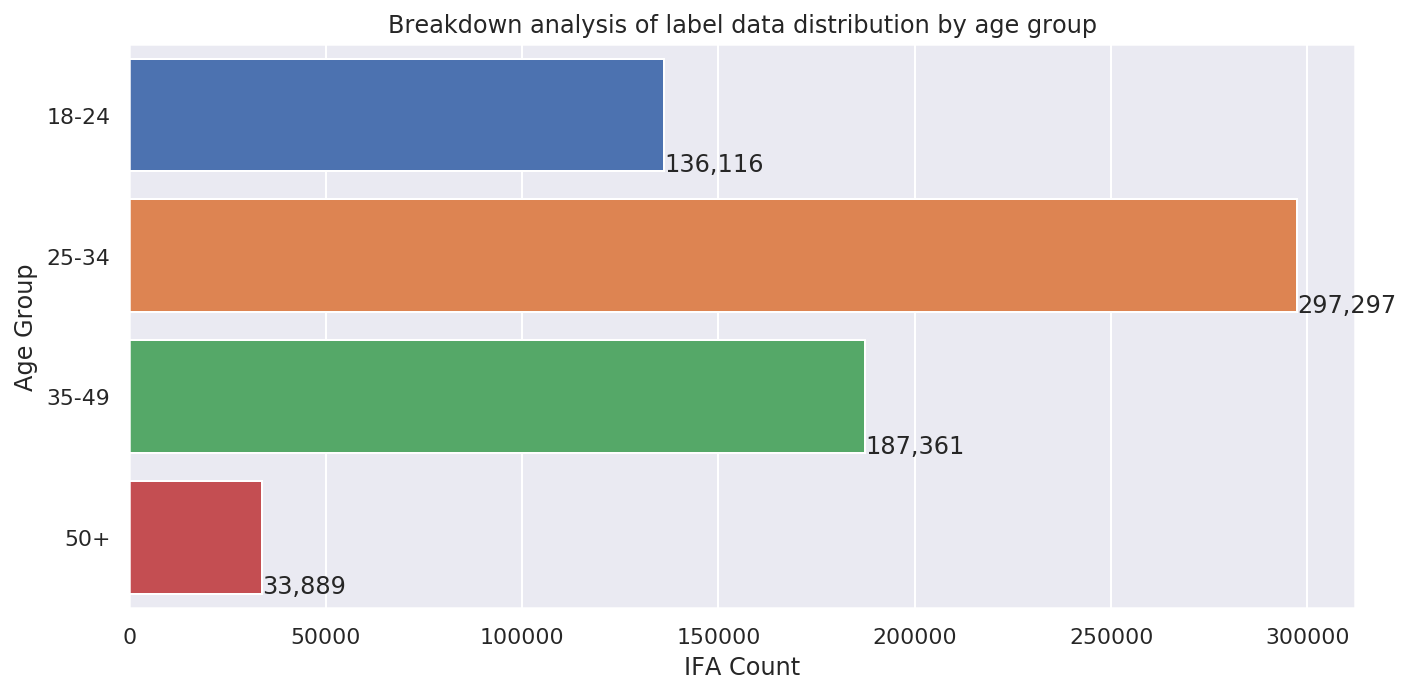

In [67]:
# Create plot
barplot = sns.barplot(y='age_group', x='count', data = age_group_count_pd, saturation=1)

# if num_categories < 10:
#     sns.set(rc={'figure.figsize':(10.0, 5.0)})
    
# Set title and x-axis ticks 
plt.title('Breakdown analysis of label data distribution by age group')
# plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("IFA Count")
plt.ylabel("Age Group")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

# 2. Which category has the highest end-user visit?

In [69]:
app_age_group_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- age_group: string (nullable = true)



In [92]:
app_genre_count = app_age_group_df.groupBy("genre").count().orderBy(F.col("count").desc())

In [93]:
app_genre_count.show()

+--------------------+------+
|               genre| count|
+--------------------+------+
|               TOOLS|202694|
|         PHOTOGRAPHY|128079|
|        PRODUCTIVITY|116204|
|     MUSIC_AND_AUDIO|112758|
|         GAME_ACTION|102827|
|           LIFESTYLE|102483|
|       COMMUNICATION| 98900|
|         GAME_PUZZLE| 85986|
|       ENTERTAINMENT| 72867|
|RAP_OR_HIP_HOP_LO...| 67051|
|       VIDEO_PLAYERS| 63120|
|         GAME_CASUAL| 61845|
|         GAME_ARCADE| 60970|
|            SHOPPING| 58165|
|     GAME_SIMULATION| 41788|
| BOOKS_AND_REFERENCE| 38982|
|     PERSONALIZATION| 36917|
|             FINANCE| 33618|
|    TRAVEL_AND_LOCAL| 32430|
|  HEALTH_AND_FITNESS| 28662|
+--------------------+------+
only showing top 20 rows



In [94]:
app_genre_count_pd = app_genre_count.toPandas()

In [95]:
# Store counts
count_ifa = app_genre_count_pd['count']

# Store max ratings
max_ifa = app_genre_count_pd['count'].max()
print(max_ifa)

202694


## Visualization for ifa count by app category

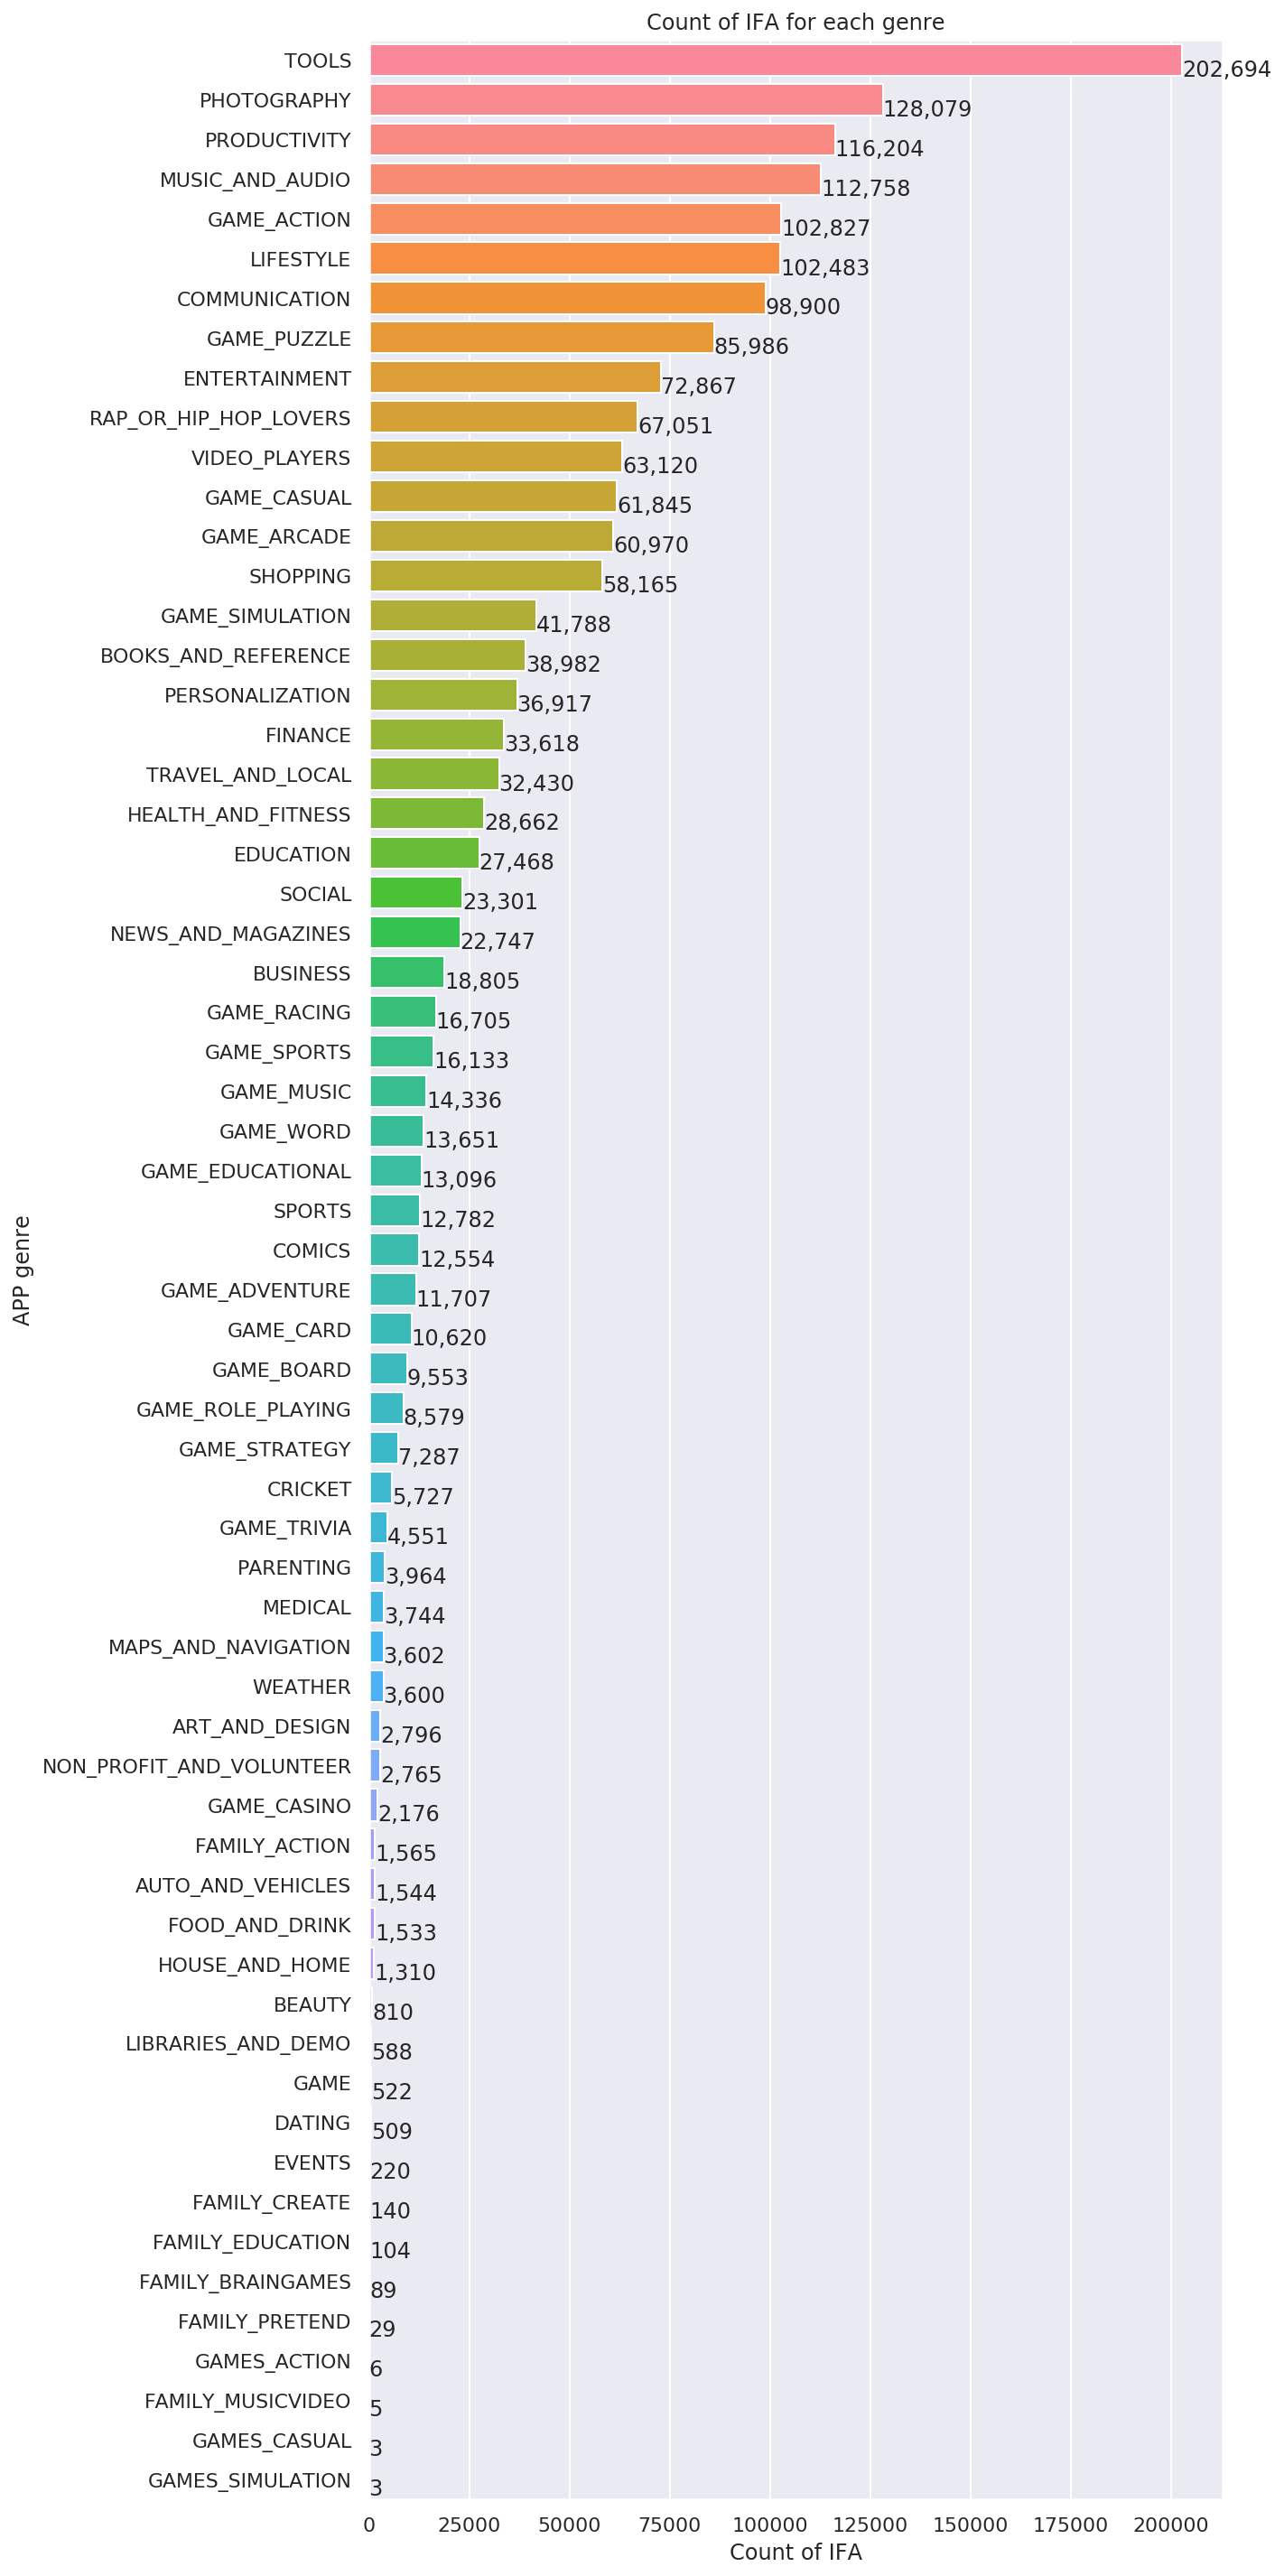

In [98]:
# Create Seaborn barplot
barplot = sns.barplot(y='genre', x='count', data = app_genre_count_pd, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 20.0)})

# Set title
plt.title("Count of IFA for each genre")

plt.xlabel("Count of IFA")
plt.ylabel("APP genre")

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.tight_layout()

# Export plot if needed
# plt.savefig('ifa_count_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

# 3. What is the breakdown per each age group for each of the app genre for a subset of data?

In [12]:
app_age_group_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- age_group: string (nullable = true)



In [50]:
app_age_group_count = app_age_group_df.groupBy("genre","age_group").count().orderBy("genre","age_group")
app_age_group_count.show()

+-------------------+---------+-----+
|              genre|age_group|count|
+-------------------+---------+-----+
|     ART_AND_DESIGN|    18-24|  563|
|     ART_AND_DESIGN|    25-34| 1056|
|     ART_AND_DESIGN|    35-49| 1039|
|     ART_AND_DESIGN|      50+|  138|
|  AUTO_AND_VEHICLES|    18-24|  171|
|  AUTO_AND_VEHICLES|    25-34|  715|
|  AUTO_AND_VEHICLES|    35-49|  601|
|  AUTO_AND_VEHICLES|      50+|   57|
|             BEAUTY|    18-24|  131|
|             BEAUTY|    25-34|  285|
|             BEAUTY|    35-49|  352|
|             BEAUTY|      50+|   42|
|BOOKS_AND_REFERENCE|    18-24| 7986|
|BOOKS_AND_REFERENCE|    25-34|15363|
|BOOKS_AND_REFERENCE|    35-49|12727|
|BOOKS_AND_REFERENCE|      50+| 2906|
|           BUSINESS|    18-24| 3412|
|           BUSINESS|    25-34| 8496|
|           BUSINESS|    35-49| 5995|
|           BUSINESS|      50+|  902|
+-------------------+---------+-----+
only showing top 20 rows



In [63]:
age_group = app_age_group_df.select("age_group").distinct()

In [67]:
genre_group = app_age_group_df.select("genre").distinct()

In [72]:
age_genre_cross_tab = genre_group.crossJoin(age_group).orderBy("genre","age_group").persist()
age_genre_cross_tab.show()

+-------------------+---------+
|              genre|age_group|
+-------------------+---------+
|     ART_AND_DESIGN|    18-24|
|     ART_AND_DESIGN|    25-34|
|     ART_AND_DESIGN|    35-49|
|     ART_AND_DESIGN|      50+|
|  AUTO_AND_VEHICLES|    18-24|
|  AUTO_AND_VEHICLES|    25-34|
|  AUTO_AND_VEHICLES|    35-49|
|  AUTO_AND_VEHICLES|      50+|
|             BEAUTY|    18-24|
|             BEAUTY|    25-34|
|             BEAUTY|    35-49|
|             BEAUTY|      50+|
|BOOKS_AND_REFERENCE|    18-24|
|BOOKS_AND_REFERENCE|    25-34|
|BOOKS_AND_REFERENCE|    35-49|
|BOOKS_AND_REFERENCE|      50+|
|           BUSINESS|    18-24|
|           BUSINESS|    25-34|
|           BUSINESS|    35-49|
|           BUSINESS|      50+|
+-------------------+---------+
only showing top 20 rows



In [73]:
app_age_group_count_join_ag = app_age_group_count.join(age_genre_cross_tab,on = ["genre","age_group"], how = "right_outer").persist()

In [78]:
app_age_group_count_join_ag = app_age_group_count_join_ag.orderBy("genre","age_group")

In [75]:
app_age_group_count_join_ag.filter(F.col("count").isNull()).show()

+-----------------+---------+-----+
|            genre|age_group|count|
+-----------------+---------+-----+
|FAMILY_MUSICVIDEO|      50+| null|
|     GAMES_ACTION|    35-49| null|
| GAMES_SIMULATION|      50+| null|
|     GAMES_CASUAL|    35-49| null|
| GAMES_SIMULATION|    35-49| null|
|     GAMES_CASUAL|      50+| null|
|FAMILY_MUSICVIDEO|    35-49| null|
|     GAMES_ACTION|      50+| null|
|   FAMILY_PRETEND|      50+| null|
| GAMES_SIMULATION|    18-24| null|
+-----------------+---------+-----+



In [79]:
app_age_group_count_join_ag = app_age_group_count_join_ag.fillna(0)

In [80]:
app_age_group_count_join_ag.filter(F.col("count").isNull()).show()

+-----+---------+-----+
|genre|age_group|count|
+-----+---------+-----+
+-----+---------+-----+



In [84]:
app_age_group_pd = app_age_group_count_join_ag.toPandas()

In [85]:
# Create grouped DataFrames by genre and by age group 
grouped_genre = app_age_group_pd.groupby('genre')
grouped_age_group = app_age_group_pd.groupby('age_group')

# Create sum of ifa count by age group
df_sum = app_age_group_pd.groupby(['age_group']).sum()

# Calculate total number of ifa counts
total = df_sum['count'].sum()
print(total)

1827575


In [53]:
df_sum

,count
age_group,
18-24,352095
25-34,795062
35-49,597136
50+,83282


In [88]:
# Create dictionary of app genres and array of ifa count distribution per age group
distribution = {}
count_ifa_per_age_grup = []
i=0
    
for genre, age_group_count in grouped_genre:
#     print(age_group_count)
    count_ifa_per_age_group = []
    for age_group in age_group_count['age_group']:
        count_ifa_per_age_group.append(age_group_count.at[i, 'count'])
        i=i+1;
    distribution[genre] = count_ifa_per_age_group

# Check if distribution has been created succesfully
print(distribution)


{'ART_AND_DESIGN': [563, 1056, 1039, 138], 'AUTO_AND_VEHICLES': [171, 715, 601, 57], 'BEAUTY': [131, 285, 352, 42], 'BOOKS_AND_REFERENCE': [7986, 15363, 12727, 2906], 'BUSINESS': [3412, 8496, 5995, 902], 'COMICS': [4264, 5553, 2534, 203], 'COMMUNICATION': [13162, 49084, 32509, 4145], 'CRICKET': [557, 3149, 1806, 215], 'DATING': [158, 238, 99, 14], 'EDUCATION': [6281, 8505, 10371, 2311], 'ENTERTAINMENT': [15649, 31013, 23102, 3103], 'EVENTS': [32, 136, 48, 4], 'FAMILY_ACTION': [100, 580, 845, 40], 'FAMILY_BRAINGAMES': [20, 32, 33, 4], 'FAMILY_CREATE': [21, 27, 85, 7], 'FAMILY_EDUCATION': [10, 41, 48, 5], 'FAMILY_MUSICVIDEO': [1, 4, 0, 0], 'FAMILY_PRETEND': [6, 8, 15, 0], 'FINANCE': [3242, 14395, 13183, 2798], 'FOOD_AND_DRINK': [131, 664, 623, 115], 'GAME': [22, 193, 291, 16], 'GAMES_ACTION': [2, 4, 0, 0], 'GAMES_CASUAL': [2, 1, 0, 0], 'GAMES_SIMULATION': [0, 3, 0, 0], 'GAME_ACTION': [25132, 45509, 30285, 1901], 'GAME_ADVENTURE': [1999, 4546, 4800, 362], 'GAME_ARCADE': [9827, 22595, 2666

In [90]:
# Build array per age group across all genres
age_group1 = []
age_group2 = []
age_group3 = []
age_group4 = []

for k in distribution.keys():
    age_groups = distribution.get(k)
#     print(age_groups)
    age_group1.append(age_groups[0])
    age_group2.append(age_groups[1])
    age_group3.append(age_groups[2])
    age_group4.append(age_groups[3])

In [119]:
np.array(age_group1)

array([  563,   171,   131,  7986,  3412,  4264, 13162,   557,   158,
        6281, 15649,    32,   100,    20,    21,    10,     1,     6,
        3242,   131,    22,     2,     2,     0, 25132,  1999,  9827,
        1845,  1647,   303,  8800,  3437,  2764, 15182,  3141,  2173,
       10037,  2920,  1509,  1377,  2477,  5889,   131,    79, 19448,
         555,   287, 25956,  1933,   597,   197,  8601, 27791, 21230,
       16139,  8402,  7625,  1380, 38404,  2587, 14130,   241])

In [ ]:
proportion_age_group1

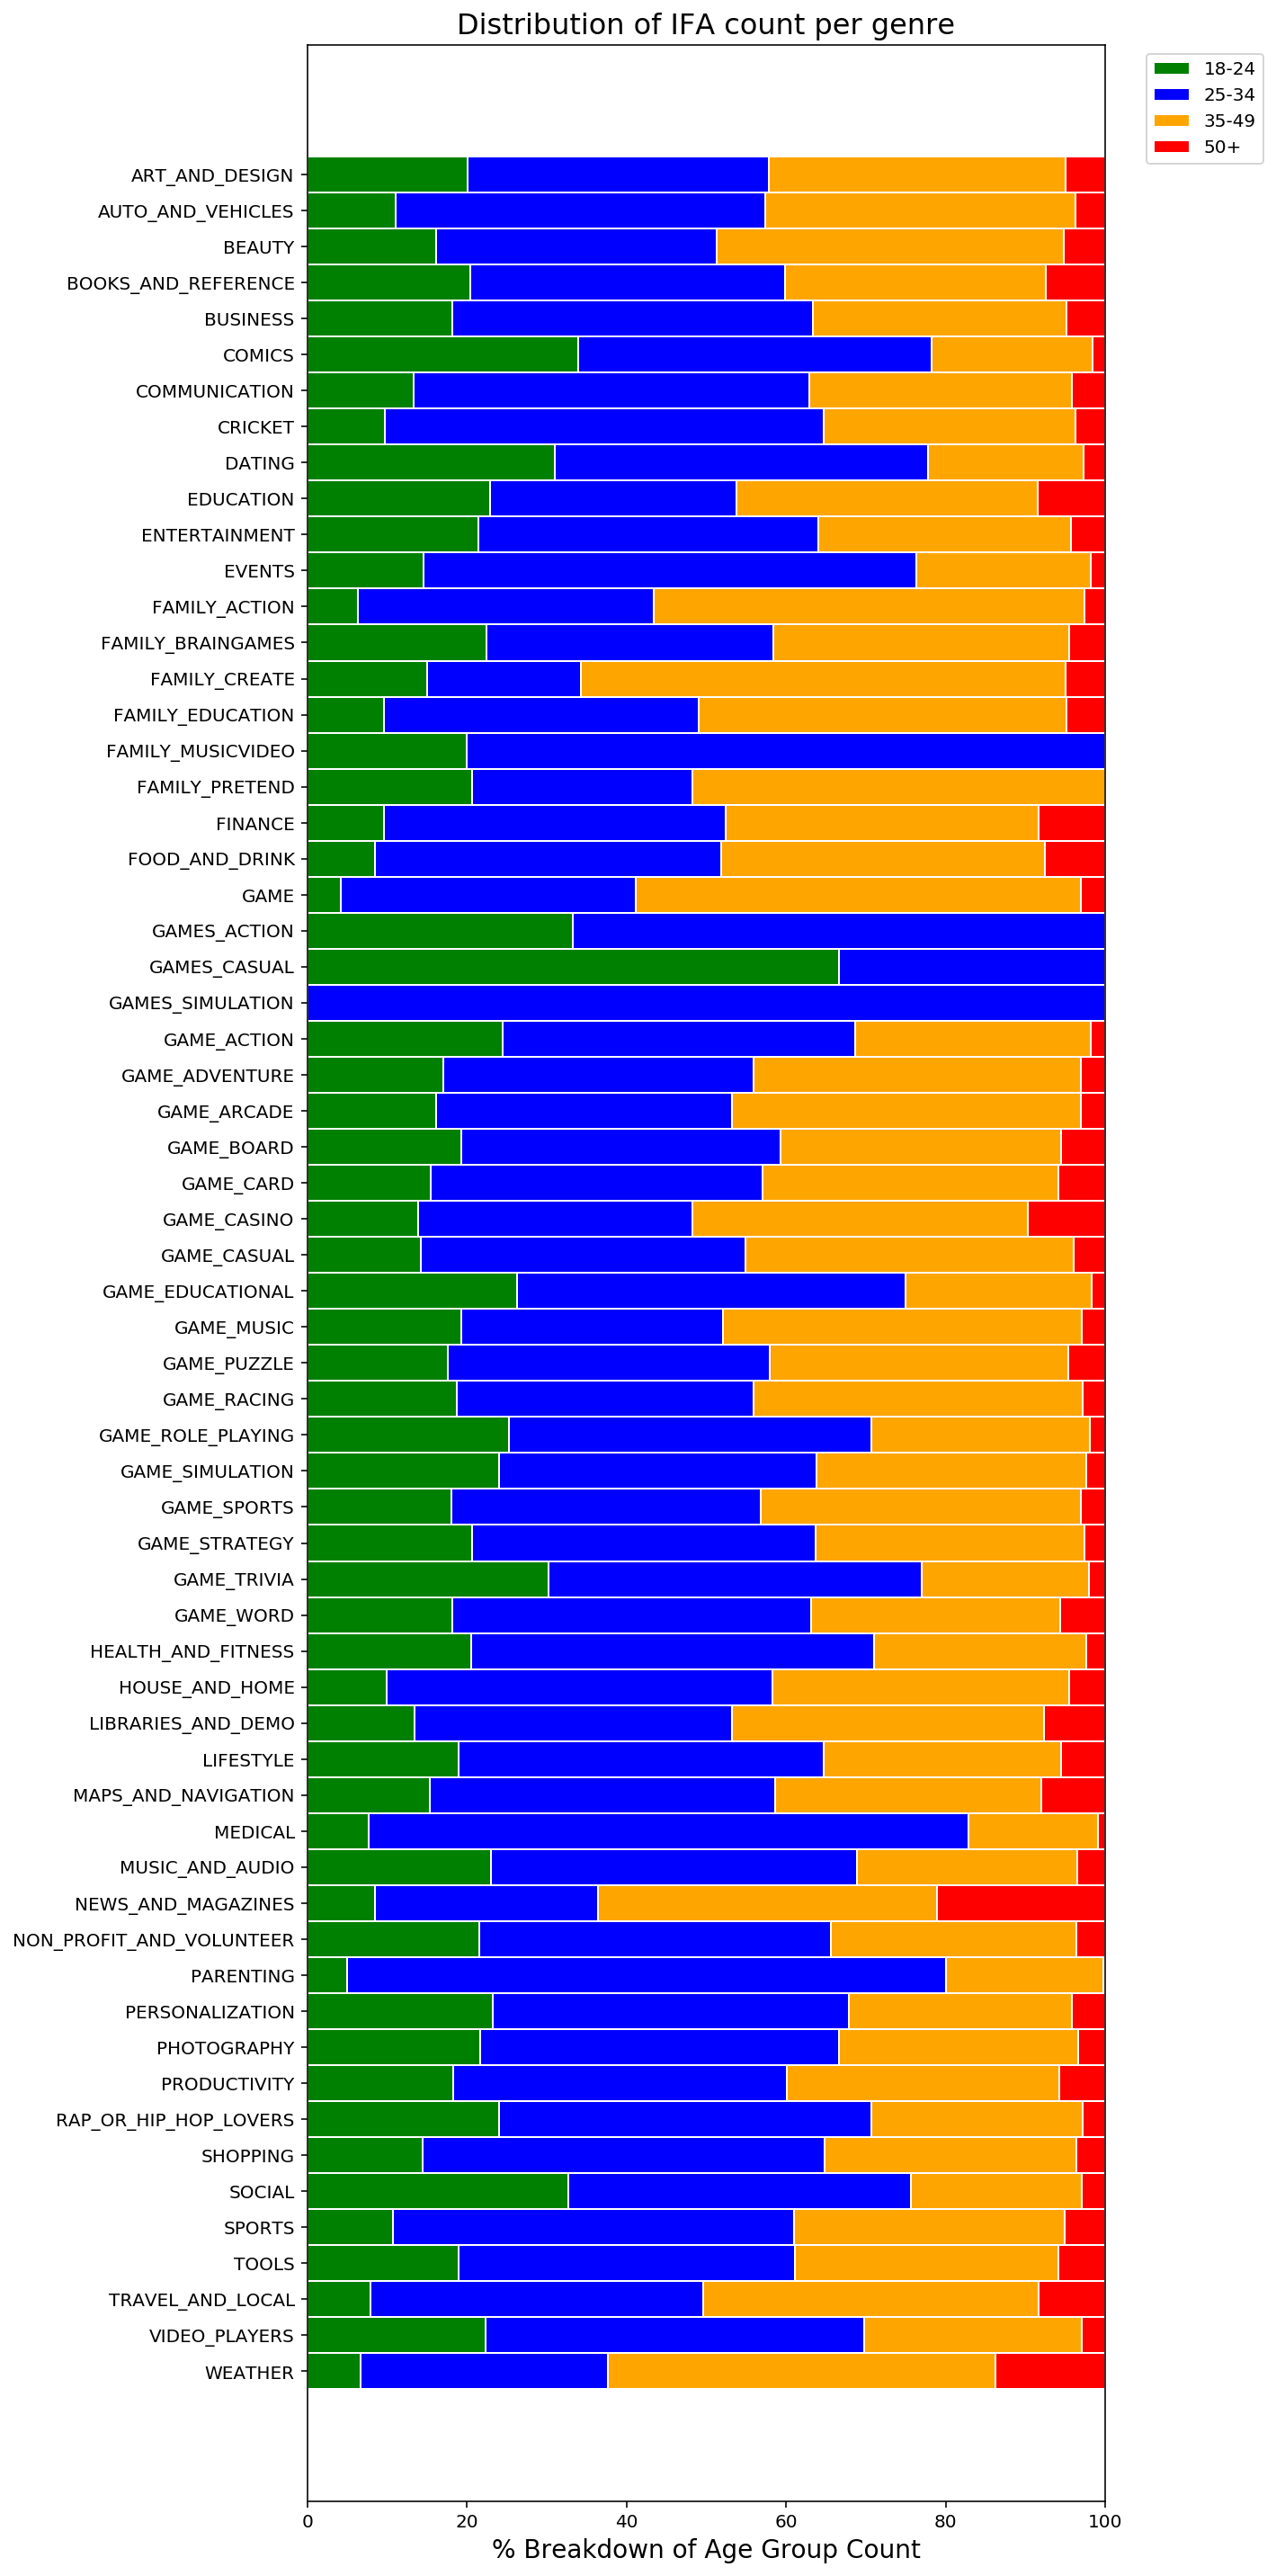

In [127]:
# Plot the distributions of age group per genre

genres = distribution.keys()

total = np.array(age_group1) + np.array(age_group2) + np.array(age_group3) + np.array(age_group4)

proportion_age_group1 = np.true_divide(age_group1, total) * 100
proportion_age_group2 = np.true_divide(age_group2, total) * 100
proportion_age_group3 = np.true_divide(age_group3, total) * 100
proportion_age_group4 = np.true_divide(age_group4, total) * 100


# Add colors
colors = ['green', 'blue','orange','red']

# The position of the bars on the x-axis
r = range(len(genres))
barHeight = 1

plt.figure(figsize=(10,20))
# Plot bars
# if num_categories > 10:
#     plt.figure(figsize=(10,20))
# else: 
#     plt.figure(figsize=(10,5))

# ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_age_group1, color=colors[0], edgecolor='white', height=barHeight, label='18-24')
ax3 = plt.barh(r, proportion_age_group2, left=proportion_age_group1, color=colors[1], edgecolor='white', height=barHeight, label='25-34')
ax2 = plt.barh(r, proportion_age_group3, left=proportion_age_group1+proportion_age_group2, color=colors[2], edgecolor='white', height=barHeight, label='35-49')
ax1 = plt.barh(r, proportion_age_group4, left=proportion_age_group1+proportion_age_group2+proportion_age_group3, color=colors[3], edgecolor='white', height=barHeight, label="50+")

plt.title("Distribution of IFA count per genre",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, genres, fontweight='regular')

plt.xlabel("% Breakdown of Age Group Count", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('proportion_age_group_ifa_count_per_genre.png', dpi=300)
plt.show()

# 4. What is the breakdown for device vendor usage for each age group?

In [110]:
device_age_group_count = device_age_group_df.where("device_vendor is NOT NULL").distinct().groupBy("age_group","device_vendor").count()

In [111]:
# create distinct age group and vendor group
age_groups = device_age_group_count.select("age_group").distinct()
vendor_groups = device_age_group_count.select("device_vendor").distinct()

In [112]:
# create cross table of age and vendor 
vendor_age_cross_tab = vendor_groups.crossJoin(age_groups)
vendor_age = vendor_age_cross_tab.join(device_age_group_count, on =["age_group","device_vendor"],how = "left_outer")
device_age_group_imputed = vendor_age.fillna(0,subset = ["count"]).orderBy("device_vendor","age_group")

In [ ]:
# convert to pandas dataframe
device_age_group_final_pd = device_age_group_imputed.toPandas()

# group by vendor and age_group
vendor_groups = device_age_group_final_pd.groupby("device_vendor")
age_groups = device_age_group_final_pd.groupby("age_group")


# Create sum of ifa count by age group
df_sum = age_groups.sum()

# Calculate total number of ifa counts
total = df_sum['count'].sum()
print(total)


# create dictionary of genre and ifa count for each age group
distribution = {}
count_ifa_per_age_grup = []
i=0
    
for vendor, age_group_count in vendor_groups:
    count_ifa_per_age_group = []
    for age_group in age_group_count['age_group']:
        count_ifa_per_age_group.append(age_group_count.at[i, 'count'])
        i=i+1;
    distribution[vendor] = count_ifa_per_age_group

# Check if distribution has been created succesfully
print(distribution)


# build array per age_group
age_group1 = []
age_group2 = []
age_group3 = []
age_group4 = []

for k in distribution.keys():
    age_groups = distribution.get(k)
#     print(age_groups)
    age_group1.append(age_groups[0])
    age_group2.append(age_groups[1])
    age_group3.append(age_groups[2])
    age_group4.append(age_groups[3])


### plot age group distribution per genre

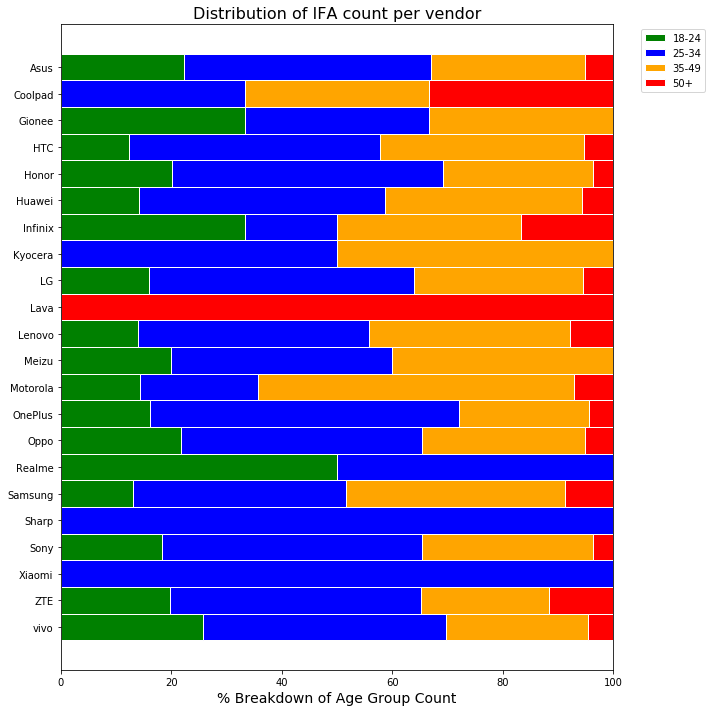

{'Asus': [942, 1883, 1181, 213], 'Coolpad': [0, 1, 1, 1], 'Gionee': [3, 3, 3, 0], 'HTC': [33, 120, 98, 14], 'Honor': [1387, 3379, 1875, 251], 'Huawei': [13774, 42955, 34505, 5457], 'Infinix': [2, 1, 2, 1], 'Kyocera': [0, 1, 1, 0], 'LG': [23, 69, 44, 8], 'Lava': [0, 0, 0, 1], 'Lenovo': [70, 207, 181, 39], 'Meizu': [1, 2, 2, 0], 'Motorola': [2, 3, 8, 1], 'OnePlus': [11, 38, 16, 3], 'Oppo': [274, 552, 371, 65], 'Realme': [1, 1, 0, 0], 'Samsung': [8916, 26287, 26943, 6008], 'Sharp': [0, 1, 0, 0], 'Sony': [88, 225, 148, 18], 'Xiaomi': [0, 1, 0, 0], 'ZTE': [17, 39, 20, 10], 'vivo': [8484, 14438, 8474, 1510]}


In [39]:
genres = distribution.keys()

# create new array with summarization of four of the age groups
total = np.array(age_group1) + np.array(age_group2) + np.array(age_group3) + np.array(age_group4)

# calculate proportion of each age group under each genre
proportion_age_group1 = np.true_divide(age_group1, total) * 100
proportion_age_group2 = np.true_divide(age_group2, total) * 100
proportion_age_group3 = np.true_divide(age_group3, total) * 100
proportion_age_group4 = np.true_divide(age_group4, total) * 100


# Add colors
colors = ['green', 'blue','orange','red']

# The position of the bars on the x-axis
r = range(len(genres))
barHeight = 1

# Plot bars
plt.figure(figsize=(10,10))

# ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_age_group1, color=colors[0], edgecolor='white', height=barHeight, label='18-24')
ax3 = plt.barh(r, proportion_age_group2, left=proportion_age_group1, color=colors[1], edgecolor='white', height=barHeight, label='25-34')
ax2 = plt.barh(r, proportion_age_group3, left=proportion_age_group1+proportion_age_group2, color=colors[2], edgecolor='white', height=barHeight, label='35-49')
ax1 = plt.barh(r, proportion_age_group4, left=proportion_age_group1+proportion_age_group2+proportion_age_group3, color=colors[3], edgecolor='white', height=barHeight, label="50+")

plt.title("Distribution of IFA count per vendor",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, genres, fontweight='regular')

plt.xlabel("% Breakdown of Age Group Count", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('proportion_age_group_ifa_count_per_vendor.png', dpi=300)
plt.show()

print(distribution)

# 5. The trend of the release year of the device for device holder?

In [42]:
device_age_group_df.printSchema()

root
 |-- ifa: string (nullable = true)
 |-- device_vendor: string (nullable = true)
 |-- device_name: string (nullable = true)
 |-- device_manufacturer: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_year_of_release: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- major_os: string (nullable = true)
 |-- age_group: string (nullable = true)



In [43]:
device_age_group_df.select("device_year_of_release").distinct().show()

+----------------------+
|device_year_of_release|
+----------------------+
|                  2016|
|                  2012|
|                  2019|
|                  2017|
|                  2014|
|                  2013|
|                  null|
|                  2018|
|                  2015|
+----------------------+



In [68]:
release_year_age_count = device_age_group_df.groupBy("device_year_of_release").count()

In [69]:
release_year_age_count.show()

+----------------------+-----+
|device_year_of_release|count|
+----------------------+-----+
|                  2016|24221|
|                  2012|   64|
|                  2019|31259|
|                  2017|58982|
|                  2014| 1414|
|                  2013| 1250|
|                  null|91413|
|                  2018|86327|
|                  2015| 9014|
+----------------------+-----+



In [70]:
release_year_age_pd = release_year_age_count.filter(F.col("device_year_of_release").isNotNull()).toPandas()

In [71]:
release_year_age_pd['year'] = pd.to_datetime(release_year_age_pd['device_year_of_release'], format='%Y').dt.year

In [79]:
release_year_age_pd = release_year_age_pd.sort_values("year")

In [80]:
release_year_age_pd

,device_year_of_release,count,year
1,2012,64,2012
5,2013,1250,2013
4,2014,1414,2014
7,2015,9014,2015
0,2016,24221,2016
3,2017,58982,2017
6,2018,86327,2018
2,2019,31259,2019


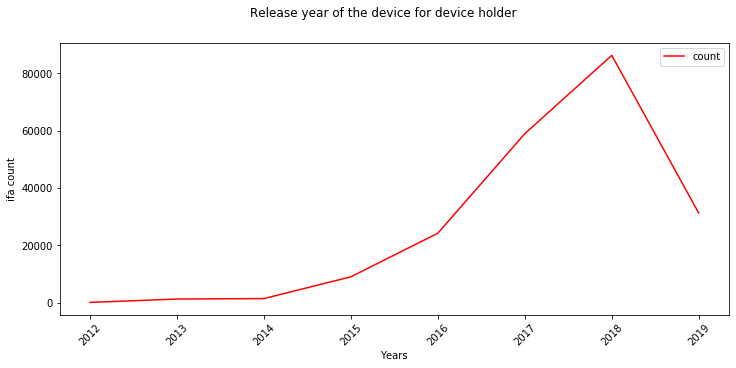

In [83]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Release year of the device for device holder')

ax = plt.gca()
#ax = plt.gca().set_xticks(df['year'])
# ax.locator_params(integer=True)
ax.set_xticks(release_year_age_pd['year'].unique())

release_year_age_pd.plot(kind='line',x='year',y='count', color='red', ax=ax)

#plt.xticks(range(1995, 2016, 1))
#plt.yticks(range(0,6,1))
plt.xlabel('Years')
plt.ylabel('ifa count')
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

# 6. device release year breakdown analysis by age group

In [69]:
def prepare_plot_df(df,column_name):

    age_group_count = df.where(column_name + " is NOT NULL").distinct().groupBy(column_name,"age_group").count()

    # create distinct age group and vendor group
    age_groups = age_group_count.select("age_group").distinct()
    genre_groups = age_group_count.select(column_name).distinct()

    # create cross table of age and vendor 
    genre_age_cross_tab = genre_groups.crossJoin(age_groups)
    genre_age = genre_age_cross_tab.join(df, on =["age_group",column_name],how = "left_outer")
    genre_age_imputed = genre_age.fillna(0,subset = ["count"]).orderBy(column_name,"age_group")

    # convert to pandas dataframe
    genre_age_pd = genre_age_imputed.toPandas()

    return genre_age_pd

def get_age_group_dist(genre_age_pd,column_name):
    # group by vendor and age_group
    genre_groups = genre_age_pd.groupby(column_name)
    age_groups = genre_age_pd.groupby("age_group")


    # Create sum of ifa count by age group
    df_sum = age_groups.sum()

    # Calculate total number of ifa counts
    total = df_sum['count'].sum()
#     print(total)


    # create dictionary of genre and ifa count for each age group
    distribution = {}
    count_ifa_per_age_grup = []
    i=0

    for genre, age_group_count in genre_groups:
        count_ifa_per_age_group = []
        for age_group in age_group_count['age_group']:
            count_ifa_per_age_group.append(age_group_count.at[i, 'count'])
            i=i+1;
        distribution[genre] = count_ifa_per_age_group

    # Check if distribution has been created succesfully
    print(distribution)
    return distribution

def plot_dist_graph(distribution,title,genre):
    # build array per age_group
    age_group1 = []
    age_group2 = []
    age_group3 = []
    age_group4 = []

    for k in distribution.keys():
        age_groups = distribution.get(k)
    #     print(age_groups)
        age_group1.append(age_groups[0])
        age_group2.append(age_groups[1])
        age_group3.append(age_groups[2])
        age_group4.append(age_groups[3])

    genres = distribution.keys()

    # create new array with summarization of four of the age groups
    total = np.array(age_group1) + np.array(age_group2) + np.array(age_group3) + np.array(age_group4)

    # calculate proportion of each age group under each genre
    proportion_age_group1 = np.true_divide(age_group1, total) * 100
    proportion_age_group2 = np.true_divide(age_group2, total) * 100
    proportion_age_group3 = np.true_divide(age_group3, total) * 100
    proportion_age_group4 = np.true_divide(age_group4, total) * 100


    # Add colors
    colors = ['green', 'blue','brown','orange']

    # The position of the bars on the x-axis
    r = range(len(genres))
    barHeight = 1

    # Plot bars
    if len(genres) < 5:
        plt.figure(figsize=(10,3))
    elif len(genres) < 10:
        plt.figure(figsize=(10,5))
    else:
        plt.figure(figsize=(10,20))

    # ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
    ax4 = plt.barh(r, proportion_age_group1, color=colors[0], edgecolor='white', height=barHeight, label='18-24')
    ax3 = plt.barh(r, proportion_age_group2, left=proportion_age_group1, color=colors[1], edgecolor='white', height=barHeight, label='25-34')
    ax2 = plt.barh(r, proportion_age_group3, left=proportion_age_group1+proportion_age_group2, color=colors[2], edgecolor='white', height=barHeight, label='35-49')
    ax1 = plt.barh(r, proportion_age_group4, left=proportion_age_group1+proportion_age_group2+proportion_age_group3, color=colors[3], edgecolor='white', height=barHeight, label="50+")

    plt.title(title,fontsize='16')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.yticks(r, genres, fontweight='regular')

    plt.xlabel("% Breakdown of Age Group Count", fontsize='14')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    plt.savefig('proportion_age_group_ifa_count_per_{}.png'.format(genre), dpi=300)
    plt.show()

    print(distribution)

In [18]:
year_age_group_count = device_age_group_df.where("device_year_of_release is NOT NULL").distinct().groupBy("device_year_of_release","age_group").count()

In [33]:
genre_age_pd

,age_group,device_year_of_release,count
0,18-24,2012,5
1,25-34,2012,22
2,35-49,2012,27
3,50+,2012,10
4,18-24,2013,152
5,25-34,2013,389
6,35-49,2013,548
7,50+,2013,152
8,18-24,2014,197
9,25-34,2014,493


In [23]:
genre_age_pd = prepare_plot_df(year_age_group_count,"device_year_of_release")

In [67]:
distribution = get_age_group_dist(genre_age_pd,"device_year_of_release")

{'2012': [5, 22, 27, 10], '2013': [152, 389, 548, 152], '2014': [197, 493, 562, 153], '2015': [1287, 3118, 3630, 905], '2016': [3730, 9445, 8851, 2041], '2017': [8876, 24708, 21074, 4041], '2018': [14918, 37922, 28398, 4794], '2019': [4863, 14109, 10783, 1504]}


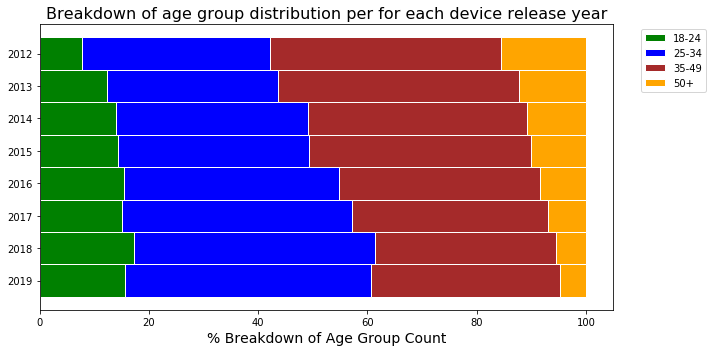

{'2012': [5, 22, 27, 10], '2013': [152, 389, 548, 152], '2014': [197, 493, 562, 153], '2015': [1287, 3118, 3630, 905], '2016': [3730, 9445, 8851, 2041], '2017': [8876, 24708, 21074, 4041], '2018': [14918, 37922, 28398, 4794], '2019': [4863, 14109, 10783, 1504]}


In [70]:
plot_dist_graph(distribution,"Breakdown of age group distribution per for each device release year","device_release_year")

# 7. Platform breakdown analysis by age group

In [44]:
device_age_group_df.select("platform").distinct().show()

+--------+
|platform|
+--------+
|   Other|
| Android|
+--------+



In [51]:
platform_age_count = device_age_group_df.where("platform is NOT NULL").distinct().groupBy("platform","age_group").count()

In [52]:
platform_age_pd = prepare_plot_df(platform_age_count,"platform")

In [71]:
distribution = get_age_group_dist(platform_age_pd,"platform")

{'Android': [53615, 131096, 98109, 18030], 'Other': [291, 783, 525, 120]}


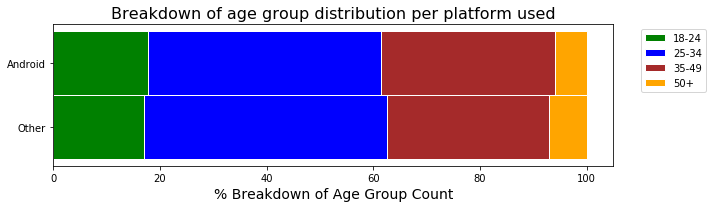

{'Android': [53615, 131096, 98109, 18030], 'Other': [291, 783, 525, 120]}


In [72]:
plot_dist_graph(distribution,"Breakdown of age group distribution per platform used","platform")

# Conclusion: